# Modeling & Fitting

In [1]:
import os
import sys
sys.path.insert(0, "../../")

import mpld3
mpld3.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

from core import util, config, database
from core.data.model import ModelDataRepo
from core.data.model.entities import *

database.init()
config.init_plot()

### Get Data

In [2]:
selected_kabko = "KOTA SURABAYA"
kabko = ModelDataRepo.get_kabko_full(selected_kabko)

### Make Model

In [3]:
from core.modeling import SeicrdRlcModel

mod = SeicrdRlcModel(kabko)

### Select Datsets to Use for Fitting

In [4]:
used_datasets = [
    #"infectious", 
    "critical_cared", 
    "infectious_all", 
    "recovered", 
    "dead",
    #"infected"
]
mod.use_datasets(used_datasets)

### List Variables that Can be Fitted

In [5]:
varying_init = [
    "death_time_over",
    "r_over", 
    "kapasitas_rs_mul", 
    "test_coverage_max", 
    "test_coverage_0", "test_coverage_increase", 
    "incubation_period", 
    "critical_time", "critical_chance",
    "death_time_normal", "death_chance_normal", 
    "k", "r_0", "r_1", "r_2"
]

### Select Variables to Fit

In [6]:
varying_now = [
    #"death_time_over",
    #"r_over", 
    #"kapasitas_rs_mul", 
    #"test_coverage_max", 
    #"test_coverage_0", "test_coverage_increase", 
    "incubation_period", 
    "critical_time", "critical_chance",
    "death_time_normal", "death_chance_normal", 
    "k", "r_0", "r_1", "r_2"
]
unvary = [x for x in varying_init if x not in varying_now]

### Fit!

In [7]:
result = mod.fit(test_splits=[], unvary=unvary)
result

### Fit Results

Params Should Have "standard error" and "relative error" Columns. If they dont:
1. A parameter might not be significant
2. A parameter has hit its min/max limit and can't vary

In [8]:
result.fit_result.params

name,value,initial value,min,max,vary
days,124.000000,124,-inf,inf,False
population,2904751.00,2904751,-inf,inf,False
infectious_rate,0.33016960,0.33017014166039804,0.07142857,0.33333333,True
critical_chance,0.41462478,0.41462566378148347,0.01000000,0.41462596,True
critical_rate,0.09079405,0.09079488784937129,0.08333333,0.33333333,True
recovery_rate_normal,0.11111111,0.1111111111111111,-inf,inf,False
recovery_rate_critical,0.15384615,0.15384615384615385,-inf,inf,False
death_chance_normal,0.45064680,0.4506471665858173,0.00500000,0.45064725,True
death_rate_normal,0.10000000,0.10000025962211982,0.10000000,0.20000000,True
death_chance_over,1.00000000,1.0,-inf,inf,False


### Model Scores

In [9]:
import math

In [24]:
if result.test_scorer:
    flat_test_scorer = result.test_scorer.flatten()
    print("Test scores")
    print("Max Error: " + str(flat_test_scorer.max_error()))
    print("MAE: " + str(flat_test_scorer.mean_absolute_error()))
    print("MSE: " + str(flat_test_scorer.mean_sqaured_error()))
    print("RMSE: " + str(flat_test_scorer.root_mean_squared_error()))
    print("RMSLE: " + str(flat_test_scorer.root_mean_squared_log_error()))
    print("Explained Variance: " + str(flat_test_scorer.explained_variance_score()))
    print("R2: " + str(flat_test_scorer.r2_score()))
    print()

In [11]:
flat_fit_scorer = result.fit_scorer.flatten()
print("Last fit scores")
print("Max Error: " + str(flat_fit_scorer.max_error()))
print("MAE: " + str(flat_fit_scorer.mean_absolute_error()))
print("MSE: " + str(flat_fit_scorer.mean_squared_error()))
print("RMSE: " + str(flat_fit_scorer.root_mean_squared_error()))
print("RMSLE: " + str(flat_fit_scorer.root_mean_squared_log_error()))
print("Explained Variance: " + str(flat_fit_scorer.explained_variance_score()))
print("R2: " + str(flat_fit_scorer.r2_score()))
print()

Last fit scores
Max Error: [1752.93941]
MAE: [307.67101207]
MSE: [281749.7959317]
RMSE: [530.80108886]
RMSLE: [1.58663628]
Explained Variance: [0.73314937]
R2: [0.696739]



### Predict

In [12]:
values = dict(result.fit_result.values)
values["days"] += 30
model_result = mod.model(**values)

### Plot!

In [13]:
from core.modeling import ModelPlotter

plotter = ModelPlotter(model_result)

In [14]:
length = kabko.data_count + result.outbreak_shift
length

124

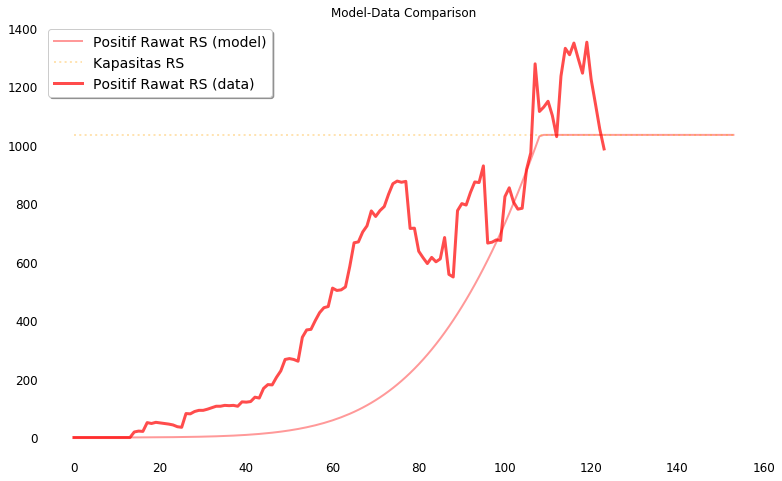

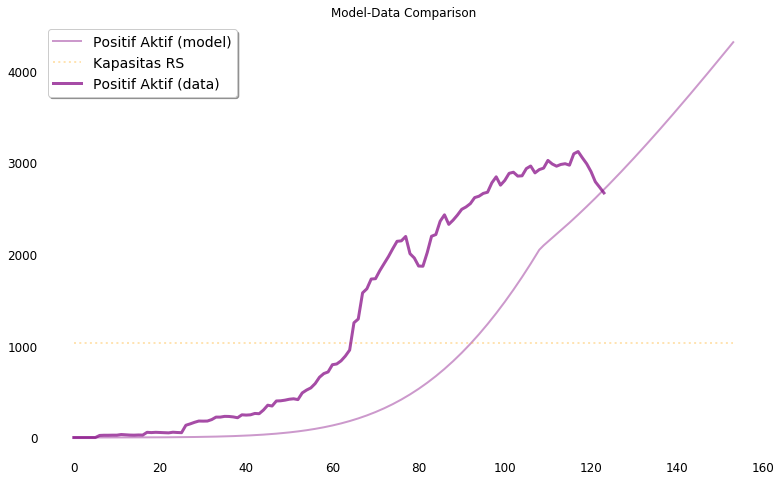

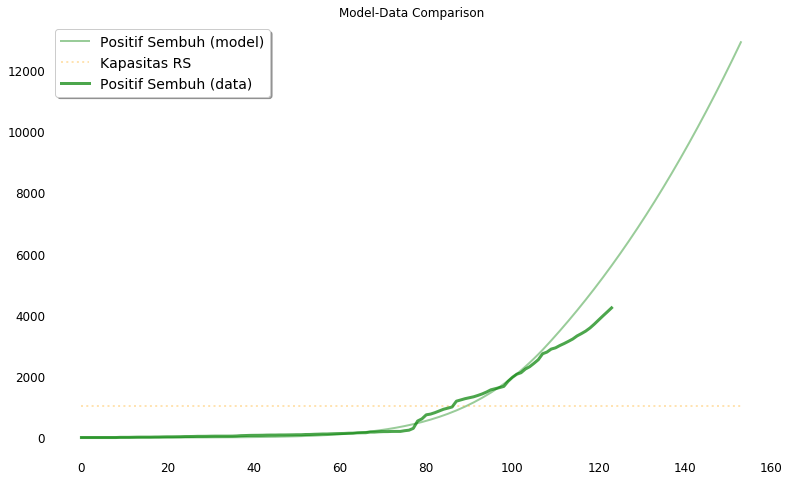

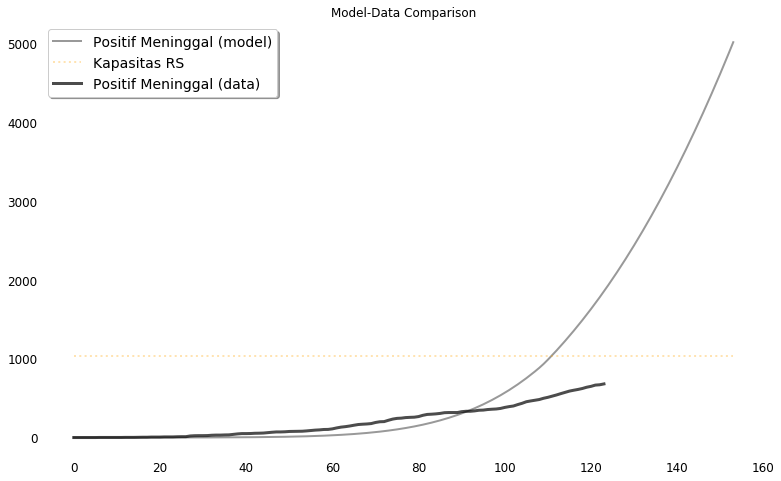

In [15]:
import matplotlib.pyplot as plt
for d in used_datasets:
    datasets = kabko.get_datasets([d], result.outbreak_shift)
    plotter.plot(
        plotter.plot_main_data, 
        datasets,
        length
    )
    plt.show()

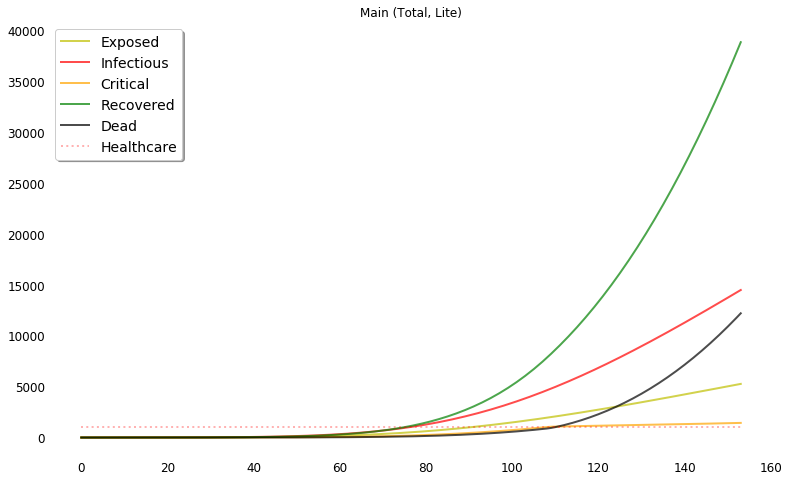

In [16]:
plotter.plot(plotter.plot_main_lite);

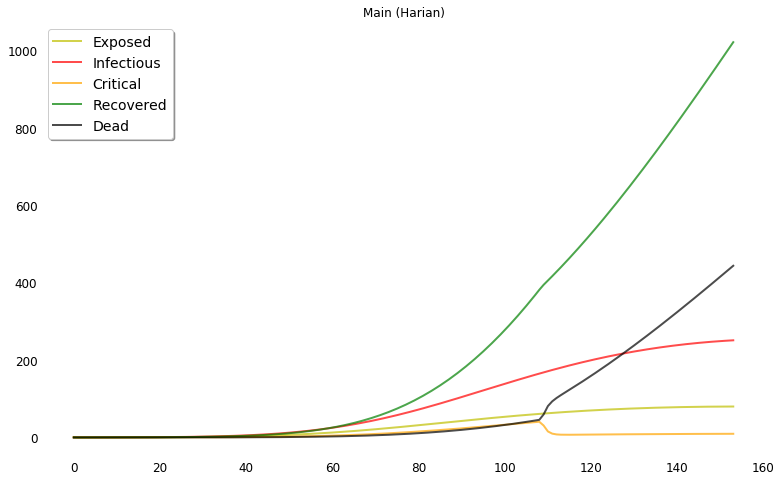

In [17]:
plotter.plot(plotter.plot_daily_lite);

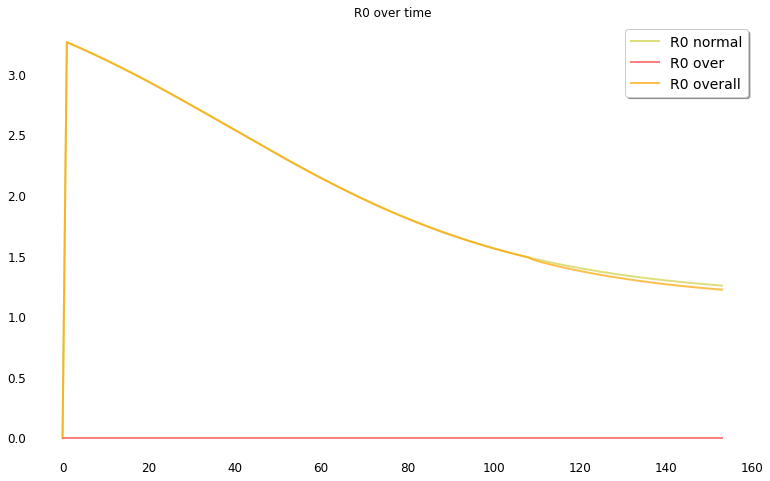

In [18]:
plotter.plot(plotter.plot_r0);

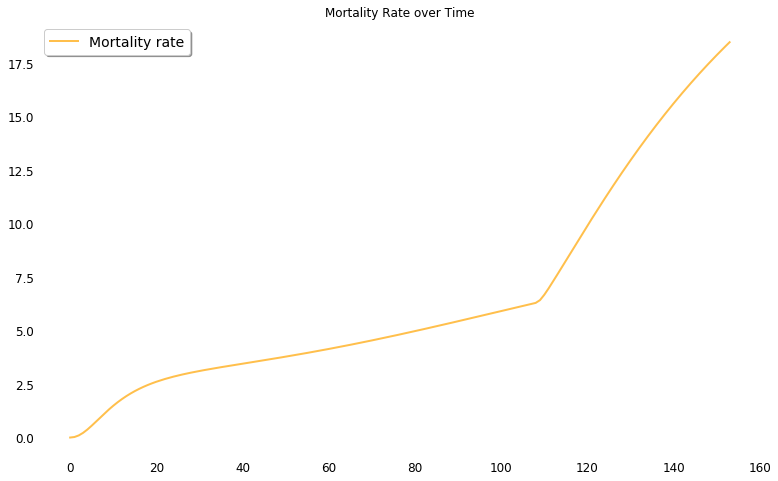

In [19]:
plotter.plot(plotter.plot_mortality_rate);

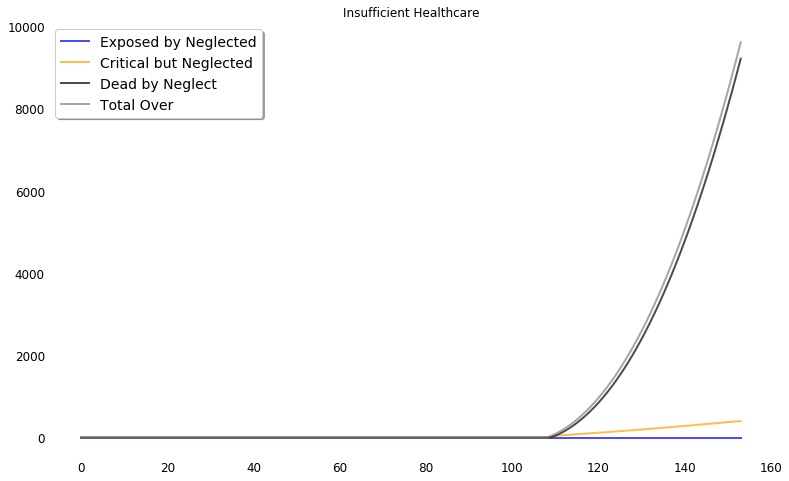

In [20]:
plotter.plot(plotter.plot_over);

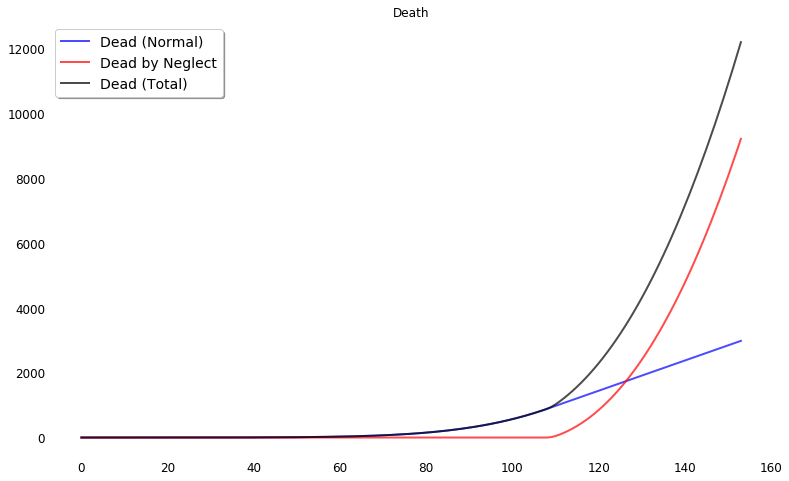

In [21]:
plotter.plot(plotter.plot_dead);

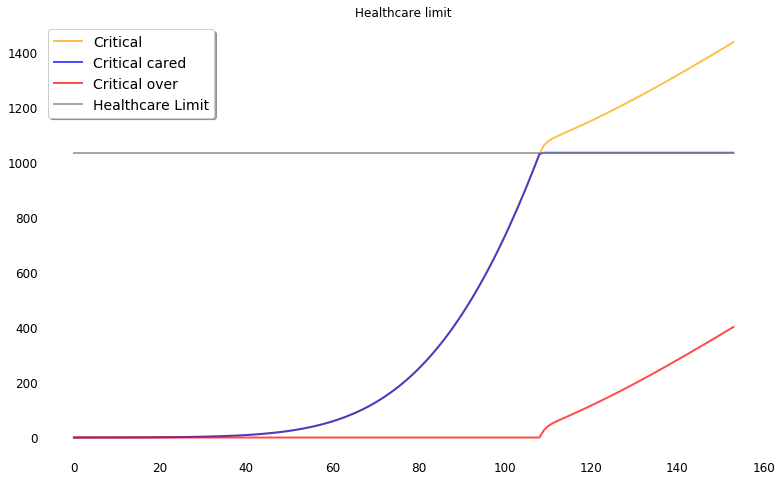

In [22]:
plotter.plot(plotter.plot_healthcare);

### Save Params

Run code below ONLY if you want to save the parameters.

In [23]:
ModelDataRepo.update_all(result.kabko, result.fit_result.values, result.outbreak_shift)

### Confidence Interval

This requires standard error to be present for each params.

result.fit_result.conf_interval()